In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
#from geopy.distance import geodesic
from pykalman import KalmanFilter
import numpy as np
from scipy import stats

In [2]:
def charger_donnees(nomcsv, nomtel):
    """Charge les données des fichiers CSV."""
    try:
        gps_data = pd.read_csv(f'results/archive/acquisitionsGPS/{nomcsv}.csv')
        tel_data = pd.read_csv(f'results/archive/acquisitionsTELEPHONE/CSV/{nomtel}.csv')
        return gps_data, tel_data
    except FileNotFoundError as e:
        print(f"Erreur : fichier non trouvé - {e}")
    except pd.errors.EmptyDataError:
        print("Erreur : un des fichiers CSV est vide.")
    except pd.errors.ParserError:
        print("Erreur : problème de format dans un fichier CSV.")
    return None, None

In [3]:
convert_time = lambda x: datetime.strptime(x, "%Y/%m/%d - %H:%M:%S").strftime("%Y-%m-%dT%H:%M:%SZ")

In [4]:
def fusionner_donnees(gps_data, tel_data):
    """Fusionne les données GPS et téléphone sur la colonne UTC."""
    return pd.merge_asof(
        gps_data.sort_values('UTC'),
        tel_data.sort_values('UTC'),
        on='UTC', suffixes=('_GPS', '_Tel')
    ).dropna()

In [5]:

def haversine_distance(lat1, lon1, lat2, lon2):
    """Calcule la distance haversine entre deux points GPS."""
    return geodesic((lat1, lon1), (lat2, lon2)).meters

In [6]:
def calculer_erreurs(merged_df):
    """Ajoute une colonne de distance et affiche les statistiques d'erreur."""
    merged_df['distance'] = merged_df.apply(lambda row: haversine_distance(
        row['Latitude_GPS'], row['Longitude_GPS'], row['Latitude_Tel'], row['Longitude_Tel']), axis=1)
    print(f"Erreur moyenne : {merged_df['distance'].mean():.2f} mètres")
    print(f"Erreur max : {merged_df['distance'].max():.2f} mètres")
    print(f"Erreur min : {merged_df['distance'].min():.2f} mètres")
    return merged_df


In [7]:
def creer_dossier_sauvegarde(nomresult):
    """Crée un dossier de sauvegarde pour les résultats."""
    output_folder = f'traitements/{nomresult}'
    os.makedirs(output_folder, exist_ok=True)
    return output_folder

In [8]:
def calculer_chemin_moyen(merged_df):
    merged_df['Latitude_corrigée'] = merged_df[['Latitude_GPS', 'Latitude_Tel']].mean(axis=1)
    merged_df['Longitude_corrigée'] = merged_df[['Longitude_GPS', 'Longitude_Tel']].mean(axis=1)

In [9]:
def generer_graphiques(merged_df, output_folder):
    """Génère et sauvegarde différents graphiques de comparaison."""
    plt.figure(figsize=(8, 6))
    plt.scatter(merged_df['Longitude_GPS'], merged_df['Latitude_GPS'], label='GPS', alpha=0.6, marker='x')
    plt.scatter(merged_df['Longitude_Tel'], merged_df['Latitude_Tel'], label='Tel', alpha=0.6, marker='x')
    plt.scatter(merged_df['Longitude_corrigée'], merged_df['Latitude_corrigée'], label='Moyen', alpha=0.6, marker='x')
    plt.legend()
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Comparaison des trajets GPS')
    plt.savefig(f'{output_folder}/comparaison_trajets.png')
    plt.show()

    plt.figure()
    plt.plot(merged_df['distance'], label='Distance GPS - Tel')
    plt.xlabel('Index')
    plt.ylabel('Distance (mètres)')
    plt.title("Évolution de l'erreur")
    plt.legend()
    plt.savefig(f'{output_folder}/erreur_evolution.png')
    plt.show()

    plt.figure()
    plt.plot(merged_df['Latitude_GPS'], label='Latitude GPS')
    plt.plot(merged_df['Latitude_Tel'], label='Latitude Tel')
    plt.legend()
    plt.savefig(f'{output_folder}/comparaison_latitude.png')
    plt.show()

    plt.figure()
    plt.plot(merged_df['Longitude_GPS'], label='Longitude GPS')
    plt.plot(merged_df['Longitude_Tel'], label='Longitude Tel')
    plt.legend()
    plt.savefig(f'{output_folder}/comparaison_longitude.png')
    plt.show()

In [10]:
def sauvegarder_resultats(merged_df, output_folder):
    output_file = f'{output_folder}/results.csv'
    merged_df.to_csv(output_file, index=False)
    print(f"Résultats sauvegardés dans : {output_file}")

In [11]:
def calculer_vitesse_acceleration(df, lat_col='Latitude_GPS', lon_col='Longitude_GPS', time_col='UTC'):
    df = df.copy().sort_values(time_col)

    df['time_diff'] = df[time_col].diff().dt.total_seconds()
    df['lat_diff'] = df[lat_col].diff()
    df['lon_diff'] = df[lon_col].diff()

    df['distance_diff'] = df.apply(
        lambda row: haversine_distance(
            row[lat_col], row[lon_col],
            row[lat_col] - row['lat_diff'],
            row[lon_col] - row['lon_diff']
        ) if not np.isnan(row['lat_diff']) else np.nan,
        axis=1
    )

    df['vitesse'] = df['distance_diff'] / df['time_diff']

    df['acceleration'] = df['vitesse'].diff() / df['time_diff']

    return df

In [12]:
def generer_boxplots(df, output_folder):
    """Génère des boxplots pour la vitesse et l'accélération avec les limites des moustaches."""
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    bp = plt.boxplot(df['vitesse'].dropna(), vert=True, patch_artist=True)
    for flier in bp['fliers']:
        flier.set(marker='o', color='red', alpha=0.5)
    plt.title('Distribution de la vitesse')
    plt.ylabel('Vitesse (m/s)')

    plt.subplot(1, 2, 2)
    bp = plt.boxplot(df['acceleration'].dropna(), vert=True, patch_artist=True)
    for flier in bp['fliers']:
        flier.set(marker='o', color='red', alpha=0.5)

    plt.title('Distribution de l\'accélération')
    plt.ylabel('Accélération (m/s²)')
    plt.tight_layout()
    plt.savefig(f'{output_folder}/boxplots_vitesse_acceleration.png')
    plt.show()

In [13]:
def identifier_valeurs_aberrantes_boxplot(df, k=1.5):
    """
    Identifie les valeurs aberrantes en utilisant les limites des boxplots (méthode IQR).
    k: facteur pour ajuster la longueur des moustaches (typiquement 1.5)
    """
    df = df.copy()

    Q1_v = df['vitesse'].quantile(0.25)
    Q3_v = df['vitesse'].quantile(0.75)
    IQR_v = Q3_v - Q1_v
    limite_basse_v = Q1_v - k * IQR_v
    limite_haute_v = Q3_v + k * IQR_v

    Q1_a = df['acceleration'].quantile(0.25)
    Q3_a = df['acceleration'].quantile(0.75)
    IQR_a = Q3_a - Q1_a
    limite_basse_a = Q1_a - k * IQR_a
    limite_haute_a = Q3_a + k * IQR_a

    df['aberrant_vitesse'] = (df['vitesse'] < limite_basse_v) | (df['vitesse'] > limite_haute_v)
    df['aberrant_acceleration'] = (df['acceleration'] < limite_basse_a) | (df['acceleration'] > limite_haute_a)
    df['aberrant'] = df['aberrant_vitesse'] | df['aberrant_acceleration']

    df['limite_basse_vitesse'] = limite_basse_v
    df['limite_haute_vitesse'] = limite_haute_v
    df['limite_basse_acceleration'] = limite_basse_a
    df['limite_haute_acceleration'] = limite_haute_a

    return df

In [14]:
def generer_graphiques_aberrants(df, output_folder):
    """Génère des graphiques montrant les valeurs aberrantes."""
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(df['vitesse'], label='Vitesse normale', color='blue')
    plt.scatter(df[df['aberrant_vitesse']].index,
                df[df['aberrant_vitesse']]['vitesse'],
                color='red', label='Valeurs aberrantes')
    plt.title('Vitesse avec valeurs aberrantes')
    plt.ylabel('Vitesse (m/s)')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(df['acceleration'], label='Accélération normale', color='green')
    plt.scatter(df[df['aberrant_acceleration']].index,
                df[df['aberrant_acceleration']]['acceleration'],
                color='red', label='Valeurs aberrantes')
    plt.title('Accélération avec valeurs aberrantes')
    plt.ylabel('Accélération (m/s²)')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{output_folder}/valeurs_aberrantes.png')
    plt.show()

In [15]:
def traitement(nomcsv, nomtel, nomresult):
    """Orchestre le traitement complet des fichiers."""
    gps_data, tel_data = charger_donnees(nomcsv, nomtel)
    if gps_data is None or tel_data is None:
        return

    gps_data['UTC'] = pd.to_datetime(gps_data['UTC'], errors='coerce')
    tel_data['UTC'] = pd.to_datetime(tel_data['UTC'], errors='coerce')

    merged_df = fusionner_donnees(gps_data, tel_data)
    merged_df = calculer_erreurs(merged_df)

    calculer_chemin_moyen(merged_df)

    merged_df = calculer_vitesse_acceleration(merged_df)

    merged_df = identifier_valeurs_aberrantes_boxplot(merged_df)

    output_folder = creer_dossier_sauvegarde(nomresult)

    generer_graphiques(merged_df, output_folder)

    generer_boxplots(merged_df, output_folder)
    generer_graphiques_aberrants(merged_df, output_folder)

    sauvegarder_resultats(merged_df, output_folder)

In [16]:
#ne fonctionne pas, il faut rajouter un paramètre à la fonction charger_donnees

traite = {"immobile_exterieur_1":("immobile_exterieur_1_gps","immobile_exterieur_1_gps_ref_1"),
          "immobile_interieur_1":("immobile_interieur_1_gps","immobile_interieur_1_gps_ref_1"),
          "mouvement_exterieur_1":("mouvement_exterieur_1_gps","mouvement_exterieur_1_gps_ref_1"),
          "mouvement_interieur_1":("mouvement_interieur_1_gps","mouvement_interieur_1_gps_ref_1"),
          "mouvement_interieur_exterieur_1":("mouvement_interieur_exterieur_1_gps","mouvement_interieur_exterieur_1_gps_ref")
        }

for itineraire in traite:
    traitement(traite[itineraire][0],traite[itineraire][1],itineraire)

Erreur : fichier non trouvé - [Errno 2] No such file or directory: 'results/archive/acquisitionsGPS/immobile_exterieur_1_gps.csv'
Erreur : fichier non trouvé - [Errno 2] No such file or directory: 'results/archive/acquisitionsGPS/immobile_interieur_1_gps.csv'
Erreur : fichier non trouvé - [Errno 2] No such file or directory: 'results/archive/acquisitionsGPS/mouvement_exterieur_1_gps.csv'
Erreur : fichier non trouvé - [Errno 2] No such file or directory: 'results/archive/acquisitionsGPS/mouvement_interieur_1_gps.csv'
Erreur : fichier non trouvé - [Errno 2] No such file or directory: 'results/archive/acquisitionsGPS/mouvement_interieur_exterieur_1_gps.csv'


In [17]:
# ancien code

traite = {"immobile_interieur1":("immobile_interieur1","immobile_interieur1"),
          "immobile_interieur2":("immobile_interieur1","IMMOBILE_INTERIEUR1_2503"),
          "immobile_exterieur1":("immobile_exterieur1","immobile_exterieur1"),
          "immobile_exterieur2":("immobile_exterieur1","IMMOBILE_EXTERIEUR1_2503"),
          "mouvement_interieur1":("mouvement_interieur1","mouvement_interieur1"),
          "mouvement_interieur2":("mouvement_interieur1","MOUVEMENT_INTERIEUR1_2503"),
          "mouvement_exterieur1":("mouvement_exterieur1","mouvement_exterieur1"),
          "mouvement_exterieur2":("mouvement_exterieur1","MOUVEMENT_EXTERIEUR1_2503")
        }

for itineraire in traite:
    traitement(traite[itineraire][0],traite[itineraire][1],itineraire)

NameError: name 'geodesic' is not defined

In [35]:
try:
    gps_data = pd.read_csv('results/mouvement_exterieur_1/mouvement_exterieur_1_gnss.csv')
    imu_data = pd.read_csv('results/mouvement_exterieur_1/mouvement_exterieur_1_imu.csv')
except FileNotFoundError as e:
    print(f"Erreur : fichier non trouvé - {e}")
except pd.errors.EmptyDataError:
    print("Erreur : un des fichiers CSV est vide.")
except pd.errors.ParserError:
    print("Erreur : problème de format dans un fichier CSV.")

In [36]:
gps_data

,Timestamp,UTC,Latitude,Longitude
0,1.745334e+09,2025/04/22 - 14:58:40,49.384319,1.067829
1,1.745334e+09,2025/04/22 - 14:58:41,49.384324,1.067827
2,1.745334e+09,2025/04/22 - 14:58:42,49.384329,1.067826
3,1.745334e+09,2025/04/22 - 14:58:43,49.384333,1.067824
4,1.745334e+09,2025/04/22 - 14:58:44,49.384338,1.067823
...,...,...,...,...
195,1.745334e+09,2025/04/22 - 15:01:46,49.384977,1.067586
196,1.745334e+09,2025/04/22 - 15:01:47,49.384970,1.067598
197,1.745334e+09,2025/04/22 - 15:01:48,49.384973,1.067617
198,1.745334e+09,2025/04/22 - 15:01:49,49.384971,1.067640


In [37]:
imu_data

,Timestamp,Accel X,Accel Y,Accel Z,Gyro X,Gyro Y,Gyro Z,Magneto X,Magneto Y,Magneto Z
0,1.745334e+09,1.071221,0.054290,0.188795,-15.23375,6.49250,-3.92875,-0.455422,0.042678,-0.203595
1,1.745334e+09,0.923174,0.077714,0.147986,-16.09125,1.46125,-5.26750,-0.455422,0.042678,-0.203595
2,1.745334e+09,0.911523,0.082472,0.148108,-14.29750,-8.75000,-5.91500,-0.455422,0.042678,-0.203595
3,1.745334e+09,0.924455,0.062098,0.128954,-7.67375,-12.44250,1.50500,-0.455422,0.042678,-0.203595
4,1.745334e+09,0.937936,0.060573,0.151524,1.12875,-0.28875,5.42500,-0.455422,0.042678,-0.203595
...,...,...,...,...,...,...,...,...,...,...
2377,1.745334e+09,0.917867,-0.231251,0.294203,20.18625,-1.52250,4.46250,-0.301958,0.310728,0.080386
2378,1.745334e+09,1.052738,-0.230336,0.335439,28.03500,-5.92375,3.16750,-0.301958,0.310728,0.080386
2379,1.745334e+09,0.944707,-0.221552,0.296887,30.86125,3.35125,14.79625,-0.301958,0.310728,0.080386
2380,1.745334e+09,0.955748,-0.261385,0.292617,28.16625,8.70625,8.48750,-0.301958,0.310728,0.080386


In [38]:
datas = pd.merge_asof(
        gps_data.sort_values('Timestamp'),
        imu_data.sort_values('Timestamp'),
        on='Timestamp', suffixes=('_GPS', '_IMU')
).dropna()

In [39]:
datas

,Timestamp,UTC,Latitude,Longitude,Accel X,Accel Y,Accel Z,Gyro X,Gyro Y,Gyro Z,Magneto X,Magneto Y,Magneto Z
0,1.745334e+09,2025/04/22 - 14:58:40,49.384319,1.067829,0.911523,0.082472,0.148108,-14.29750,-8.75000,-5.91500,-0.455422,0.042678,-0.203595
1,1.745334e+09,2025/04/22 - 14:58:41,49.384324,1.067827,1.050176,0.058560,0.094977,13.83375,-25.38375,-7.33250,-0.455422,0.042678,-0.203595
2,1.745334e+09,2025/04/22 - 14:58:42,49.384329,1.067826,1.000705,0.064965,0.102419,-0.07000,-0.10500,0.32375,-0.508039,0.080386,-0.180357
3,1.745334e+09,2025/04/22 - 14:58:43,49.384333,1.067824,1.000583,0.064660,0.101748,-0.06125,-0.09625,0.32375,-0.508039,0.080386,-0.180357
4,1.745334e+09,2025/04/22 - 14:58:44,49.384338,1.067823,1.066219,-0.076250,0.139446,-58.64250,12.13625,-15.18125,-0.510962,0.073078,-0.179918
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.745334e+09,2025/04/22 - 15:01:46,49.384977,1.067586,0.965386,-0.339465,0.288530,34.71125,1.90750,-10.43875,-0.323882,0.136510,0.190588
196,1.745334e+09,2025/04/22 - 15:01:47,49.384970,1.067598,1.154608,-0.194529,0.115595,3.42125,-6.28250,-14.06125,-0.312189,0.246711,0.074540
197,1.745334e+09,2025/04/22 - 15:01:48,49.384973,1.067617,0.794525,-0.099613,0.082289,16.85250,-23.43250,8.73250,-0.278281,0.326220,-0.089594
198,1.745334e+09,2025/04/22 - 15:01:49,49.384971,1.067640,0.709125,-0.125172,0.105103,35.97125,-2.59000,16.56375,-0.278281,0.326220,-0.089594


In [40]:
# Exemple de données pour w0
w0 = np.array([datas["Magneto X"][0], datas["Magneto Y"][0], datas["Magneto Z"][0]])

# Norme du vecteur du champ magnétique
norme_w0 = np.linalg.norm(w0)

theta_x = np.arccos(w0[0] / norme_w0)
theta_y = np.arccos(w0[1] / norme_w0)
theta_z = np.arccos(w0[2] / norme_w0)

theta_x_deg = np.degrees(theta_x)
theta_y_deg = np.degrees(theta_y)
theta_z_deg = np.degrees(theta_z)

print(f"L'angle par rapport à l'axe x est de {theta_x_deg:.2f}°")
print(f"L'angle par rapport à l'axe y est de {theta_y_deg:.2f}°")
print(f"L'angle par rapport à l'axe z est de {theta_z_deg:.2f}°")

w0 = np.array([theta_x, theta_y, theta_z])

L'angle par rapport à l'axe x est de 155.45°
L'angle par rapport à l'axe y est de 85.11°
L'angle par rapport à l'axe z est de 113.99°


In [41]:
Rt = 6371000
datas["x"] = Rt * np.cos(np.radians(datas["Latitude"])) * np.cos(np.radians(datas["Longitude"]))
datas["y"] = Rt * np.cos(np.radians(datas["Latitude"])) * np.sin(np.radians(datas["Longitude"]))
datas["z"] = Rt * np.sin(np.radians(datas["Latitude"]))

datas

,Timestamp,UTC,Latitude,Longitude,Accel X,Accel Y,Accel Z,Gyro X,Gyro Y,Gyro Z,Magneto X,Magneto Y,Magneto Z,x,y,z
0,1.745334e+09,2025/04/22 - 14:58:40,49.384319,1.067829,0.911523,0.082472,0.148108,-14.29750,-8.75000,-5.91500,-0.455422,0.042678,-0.203595,4.146686e+06,77291.282566,4.836183e+06
1,1.745334e+09,2025/04/22 - 14:58:41,49.384324,1.067827,1.050176,0.058560,0.094977,13.83375,-25.38375,-7.33250,-0.455422,0.042678,-0.203595,4.146686e+06,77291.166403,4.836183e+06
2,1.745334e+09,2025/04/22 - 14:58:42,49.384329,1.067826,1.000705,0.064965,0.102419,-0.07000,-0.10500,0.32375,-0.508039,0.080386,-0.180357,4.146685e+06,77291.051026,4.836183e+06
3,1.745334e+09,2025/04/22 - 14:58:43,49.384333,1.067824,1.000583,0.064660,0.101748,-0.06125,-0.09625,0.32375,-0.508039,0.080386,-0.180357,4.146685e+06,77290.922801,4.836184e+06
4,1.745334e+09,2025/04/22 - 14:58:44,49.384338,1.067823,1.066219,-0.076250,0.139446,-58.64250,12.13625,-15.18125,-0.510962,0.073078,-0.179918,4.146684e+06,77290.795363,4.836184e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.745334e+09,2025/04/22 - 15:01:46,49.384977,1.067586,0.965386,-0.339465,0.288530,34.71125,1.90750,-10.43875,-0.323882,0.136510,0.190588,4.146631e+06,77272.673356,4.836230e+06
196,1.745334e+09,2025/04/22 - 15:01:47,49.384970,1.067598,1.154608,-0.194529,0.115595,3.42125,-6.28250,-14.06125,-0.312189,0.246711,0.074540,4.146631e+06,77273.552833,4.836230e+06
197,1.745334e+09,2025/04/22 - 15:01:48,49.384973,1.067617,0.794525,-0.099613,0.082289,16.85250,-23.43250,8.73250,-0.278281,0.326220,-0.089594,4.146631e+06,77274.911390,4.836230e+06
198,1.745334e+09,2025/04/22 - 15:01:49,49.384971,1.067640,0.709125,-0.125172,0.105103,35.97125,-2.59000,16.56375,-0.278281,0.326220,-0.089594,4.146631e+06,77276.578575,4.836230e+06


In [42]:
gyro = datas[["Gyro X", "Gyro Y", "Gyro Z"]].to_numpy()
wk = np.zeros_like(gyro)
wk[0] = w0 + gyro[0]
for k in range(1, len(gyro)):
    wk[k] = wk[k-1] + gyro[k]
datas["w_x"] = wk[:, 0]
datas["w_y"] = wk[:, 1]
datas["w_z"] = wk[:, 2]
datas

,Timestamp,UTC,Latitude,Longitude,Accel X,Accel Y,Accel Z,Gyro X,Gyro Y,Gyro Z,Magneto X,Magneto Y,Magneto Z,x,y,z,w_x,w_y,w_z
0,1.745334e+09,2025/04/22 - 14:58:40,49.384319,1.067829,0.911523,0.082472,0.148108,-14.29750,-8.75000,-5.91500,-0.455422,0.042678,-0.203595,4.146686e+06,77291.282566,4.836183e+06,-11.584372,-7.264546,-3.925434
1,1.745334e+09,2025/04/22 - 14:58:41,49.384324,1.067827,1.050176,0.058560,0.094977,13.83375,-25.38375,-7.33250,-0.455422,0.042678,-0.203595,4.146686e+06,77291.166403,4.836183e+06,2.249378,-32.648296,-11.257934
2,1.745334e+09,2025/04/22 - 14:58:42,49.384329,1.067826,1.000705,0.064965,0.102419,-0.07000,-0.10500,0.32375,-0.508039,0.080386,-0.180357,4.146685e+06,77291.051026,4.836183e+06,2.179378,-32.753296,-10.934184
3,1.745334e+09,2025/04/22 - 14:58:43,49.384333,1.067824,1.000583,0.064660,0.101748,-0.06125,-0.09625,0.32375,-0.508039,0.080386,-0.180357,4.146685e+06,77290.922801,4.836184e+06,2.118128,-32.849546,-10.610434
4,1.745334e+09,2025/04/22 - 14:58:44,49.384338,1.067823,1.066219,-0.076250,0.139446,-58.64250,12.13625,-15.18125,-0.510962,0.073078,-0.179918,4.146684e+06,77290.795363,4.836184e+06,-56.524372,-20.713296,-25.791684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.745334e+09,2025/04/22 - 15:01:46,49.384977,1.067586,0.965386,-0.339465,0.288530,34.71125,1.90750,-10.43875,-0.323882,0.136510,0.190588,4.146631e+06,77272.673356,4.836230e+06,216.449378,-89.497046,103.209566
196,1.745334e+09,2025/04/22 - 15:01:47,49.384970,1.067598,1.154608,-0.194529,0.115595,3.42125,-6.28250,-14.06125,-0.312189,0.246711,0.074540,4.146631e+06,77273.552833,4.836230e+06,219.870628,-95.779546,89.148316
197,1.745334e+09,2025/04/22 - 15:01:48,49.384973,1.067617,0.794525,-0.099613,0.082289,16.85250,-23.43250,8.73250,-0.278281,0.326220,-0.089594,4.146631e+06,77274.911390,4.836230e+06,236.723128,-119.212046,97.880816
198,1.745334e+09,2025/04/22 - 15:01:49,49.384971,1.067640,0.709125,-0.125172,0.105103,35.97125,-2.59000,16.56375,-0.278281,0.326220,-0.089594,4.146631e+06,77276.578575,4.836230e+06,272.694378,-121.802046,114.444566


In [43]:
from scipy.spatial.transform import Rotation as R

accel = datas[["Accel X", "Accel Y", "Accel Z"]].to_numpy()

accel_corr = np.zeros_like(accel)

for k in range(len(accel)):
    w = wk[k]
    angle = np.linalg.norm(w)
    if angle != 0:
        axis = -w / angle
        rot = R.from_rotvec(axis * angle)
        accel_corr[k] = rot.apply(accel[k])
    else:
        accel_corr[k] = accel[k]

datas["Accel_corr_X"] = accel_corr[:, 0]
datas["Accel_corr_Y"] = accel_corr[:, 1]
datas["Accel_corr_Z"] = accel_corr[:, 2]

datas

,Timestamp,UTC,Latitude,Longitude,Accel X,Accel Y,Accel Z,Gyro X,Gyro Y,Gyro Z,...,Magneto Z,x,y,z,w_x,w_y,w_z,Accel_corr_X,Accel_corr_Y,Accel_corr_Z
0,1.745334e+09,2025/04/22 - 14:58:40,49.384319,1.067829,0.911523,0.082472,0.148108,-14.29750,-8.75000,-5.91500,...,-0.203595,4.146686e+06,77291.282566,4.836183e+06,-11.584372,-7.264546,-3.925434,0.703407,0.581892,-0.161963
1,1.745334e+09,2025/04/22 - 14:58:41,49.384324,1.067827,1.050176,0.058560,0.094977,13.83375,-25.38375,-7.33250,...,-0.203595,4.146686e+06,77291.166403,4.836183e+06,2.249378,-32.648296,-11.257934,-1.054721,-0.042308,-0.033070
2,1.745334e+09,2025/04/22 - 14:58:42,49.384329,1.067826,1.000705,0.064965,0.102419,-0.07000,-0.10500,0.32375,...,-0.180357,4.146685e+06,77291.051026,4.836183e+06,2.179378,-32.753296,-10.934184,-1.006893,-0.019911,-0.043484
3,1.745334e+09,2025/04/22 - 14:58:43,49.384333,1.067824,1.000583,0.064660,0.101748,-0.06125,-0.09625,0.32375,...,-0.180357,4.146685e+06,77290.922801,4.836184e+06,2.118128,-32.849546,-10.610434,-1.006182,-0.013871,-0.055726
4,1.745334e+09,2025/04/22 - 14:58:44,49.384338,1.067823,1.066219,-0.076250,0.139446,-58.64250,12.13625,-15.18125,...,-0.179918,4.146684e+06,77290.795363,4.836184e+06,-56.524372,-20.713296,-25.791684,0.637519,0.773616,0.396446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.745334e+09,2025/04/22 - 15:01:46,49.384977,1.067586,0.965386,-0.339465,0.288530,34.71125,1.90750,-10.43875,...,0.190588,4.146631e+06,77272.673356,4.836230e+06,216.449378,-89.497046,103.209566,0.918454,-0.225328,0.485928
196,1.745334e+09,2025/04/22 - 15:01:47,49.384970,1.067598,1.154608,-0.194529,0.115595,3.42125,-6.28250,-14.06125,...,0.074540,4.146631e+06,77273.552833,4.836230e+06,219.870628,-95.779546,89.148316,0.937276,-0.154945,0.694139
197,1.745334e+09,2025/04/22 - 15:01:48,49.384973,1.067617,0.794525,-0.099613,0.082289,16.85250,-23.43250,8.73250,...,-0.089594,4.146631e+06,77274.911390,4.836230e+06,236.723128,-119.212046,97.880816,0.790895,-0.062626,0.136117
198,1.745334e+09,2025/04/22 - 15:01:49,49.384971,1.067640,0.709125,-0.125172,0.105103,35.97125,-2.59000,16.56375,...,-0.089594,4.146631e+06,77276.578575,4.836230e+06,272.694378,-121.802046,114.444566,0.690321,-0.056195,0.223319


In [44]:
import numpy as np
import pandas as pd
from pykalman import KalmanFilter

# On suppose que tu as un DataFrame `datas` avec les colonnes suivantes :
# "Accel_corr_X", "Accel_corr_Y", "Accel_corr_Z", "x", "y", "z"

dt = 1.0  # intervalle de temps en secondes

# Matrice de transition (état = [x, y, z, vx, vy, vz])
F = np.array([
    [1, 0, 0, dt, 0, 0],
    [0, 1, 0, 0, dt, 0],
    [0, 0, 1, 0, 0, dt],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1],
])

# Matrice de commande B (accélération intégrée)
B = np.array([
    [0.5 * dt**2, 0, 0],
    [0, 0.5 * dt**2, 0],
    [0, 0, 0.5 * dt**2],
    [dt, 0, 0],
    [0, dt, 0],
    [0, 0, dt],
])

# Observation partielle : on observe uniquement les positions (x, y, z)
H = np.zeros((3, 6))
H[0, 0] = 1
H[1, 1] = 1
H[2, 2] = 1

# Extraction des commandes (accélérations corrigées)
U = datas[["Accel_corr_X", "Accel_corr_Y", "Accel_corr_Z"]].values

# Extraction des observations (positions mesurées)
observations = datas[["x", "y", "z"]].values

# Initialisation de l'état [x, y, z, vx, vy, vz]
initial_position = datas.loc[0, ["x", "y", "z"]].values
initial_velocity = np.zeros(3)
initial_state = np.concatenate([initial_position, initial_velocity])
initial_covariance = np.eye(6) * 0.1

# Initialisation du filtre
kf = KalmanFilter(
    transition_matrices=F,
    observation_matrices=H,
    transition_covariance=np.eye(6) * 0.01,
    observation_covariance=np.eye(3) * 1,
    initial_state_mean=initial_state,
    initial_state_covariance=initial_covariance,
)

# Boucle de filtrage manuelle
filtered_states = []
state_mean = initial_state
state_cov = initial_covariance

for t in range(len(U)):
    u = U[t]
    control_effect = B @ u

    # Prédiction
    state_mean = F @ state_mean + control_effect
    state_cov = F @ state_cov @ F.T + kf.transition_covariance

    # Mise à jour avec observation de position
    observation = observations[t]
    state_mean, state_cov = kf.filter_update(
        filtered_state_mean=state_mean,
        filtered_state_covariance=state_cov,
        observation=observation
    )

    filtered_states.append(state_mean)

# Résultat final : tableau numpy (N, 6) avec positions et vitesses
filtered_states = np.array(filtered_states)

# Tu peux l’ajouter au DataFrame si tu veux
datas["x_kf"] = filtered_states[:, 0]
datas["y_kf"] = filtered_states[:, 1]
datas["z_kf"] = filtered_states[:, 2]
datas["vx_kf"] = filtered_states[:, 3]
datas["vy_kf"] = filtered_states[:, 4]
datas["vz_kf"] = filtered_states[:, 5]


Erreur moyenne en x : -2.531 m
Erreur moyenne en y : -0.190 m
Erreur moyenne en z : -1.262 m
Écart-type de l'erreur en x : 12973.429 m
Écart-type de l'erreur en y : 241.917 m
Écart-type de l'erreur en z : 10714.412 m
Corrélation entre x et x_kf : 0.819
Corrélation entre y et y_kf : 0.817
Corrélation entre z et z_kf : 0.819


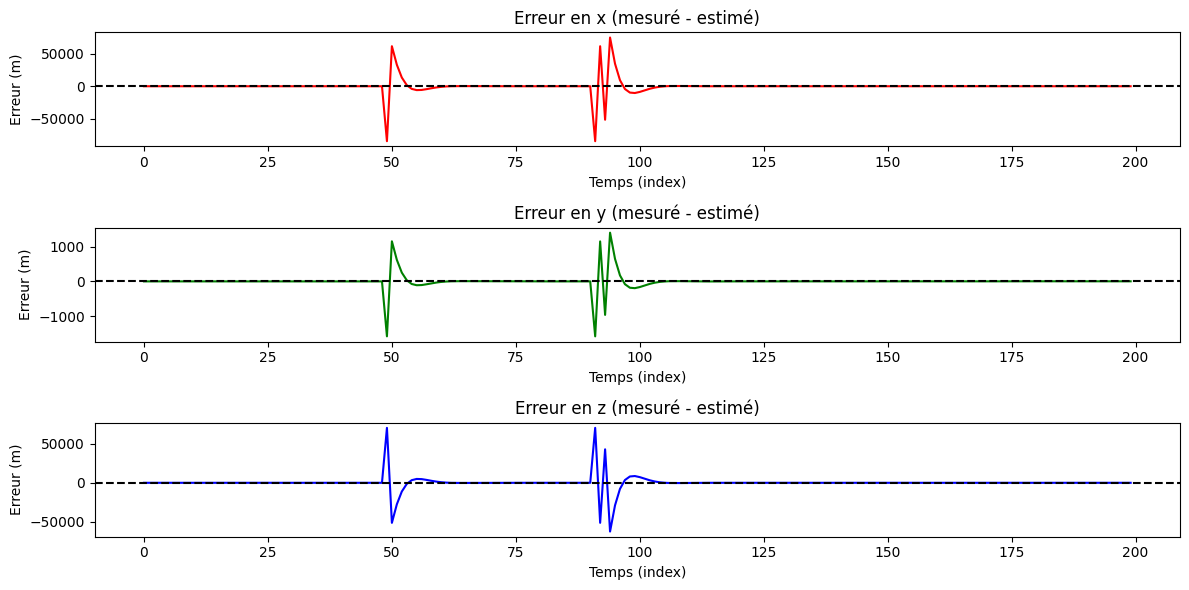

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Calcul des erreurs entre mesures et estimations (filtrées)
datas['error_x'] = datas['x'] - datas['x_kf']
datas['error_y'] = datas['y'] - datas['y_kf']
datas['error_z'] = datas['z'] - datas['z_kf']

# Calcul des statistiques pour l'erreur
error_x_mean = datas['error_x'].mean()
error_y_mean = datas['error_y'].mean()
error_z_mean = datas['error_z'].mean()

error_x_std = datas['error_x'].std()
error_y_std = datas['error_y'].std()
error_z_std = datas['error_z'].std()

# Affichage des résultats statistiques
print(f"Erreur moyenne en x : {error_x_mean:.3f} m")
print(f"Erreur moyenne en y : {error_y_mean:.3f} m")
print(f"Erreur moyenne en z : {error_z_mean:.3f} m")

print(f"Écart-type de l'erreur en x : {error_x_std:.3f} m")
print(f"Écart-type de l'erreur en y : {error_y_std:.3f} m")
print(f"Écart-type de l'erreur en z : {error_z_std:.3f} m")

# Suppression des lignes contenant des NaN pour les colonnes concernées
valid_data = datas[['x', 'x_kf', 'y', 'y_kf', 'z', 'z_kf']].dropna()

# Conversion explicite en tableaux NumPy
x_meas = valid_data['x'].to_numpy()
x_kf = valid_data['x_kf'].to_numpy()
y_meas = valid_data['y'].to_numpy()
y_kf = valid_data['y_kf'].to_numpy()
z_meas = valid_data['z'].to_numpy()
z_kf = valid_data['z_kf'].to_numpy()

# Fonction de corrélation sûre
def safe_corrcoef(a, b):
    try:
        a = np.asarray(a, dtype=np.float64)
        b = np.asarray(b, dtype=np.float64)
    except ValueError:
        return np.nan  # Cas où la conversion échoue
    if len(a) < 2 or len(b) < 2 or np.isnan(a).any() or np.isnan(b).any():
        return np.nan
    return np.corrcoef(a, b)[0, 1]


# Calcul des corrélations
corr_x = safe_corrcoef(x_meas, x_kf)
corr_y = safe_corrcoef(y_meas, y_kf)
corr_z = safe_corrcoef(z_meas, z_kf)

# Affichage des corrélations
if not np.isnan(corr_x):
    print(f"Corrélation entre x et x_kf : {corr_x:.3f}")
else:
    print("Corrélation entre x et x_kf : données insuffisantes ou invalides")

if not np.isnan(corr_y):
    print(f"Corrélation entre y et y_kf : {corr_y:.3f}")
else:
    print("Corrélation entre y et y_kf : données insuffisantes ou invalides")

if not np.isnan(corr_z):
    print(f"Corrélation entre z et z_kf : {corr_z:.3f}")
else:
    print("Corrélation entre z et z_kf : données insuffisantes ou invalides")

# Visualisation des erreurs
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(datas['error_x'], label='Erreur en x', color='r')
plt.axhline(0, color='black', linestyle='--')
plt.title('Erreur en x (mesuré - estimé)')
plt.xlabel('Temps (index)')
plt.ylabel('Erreur (m)')

plt.subplot(3, 1, 2)
plt.plot(datas['error_y'], label='Erreur en y', color='g')
plt.axhline(0, color='black', linestyle='--')
plt.title('Erreur en y (mesuré - estimé)')
plt.xlabel('Temps (index)')
plt.ylabel('Erreur (m)')

plt.subplot(3, 1, 3)
plt.plot(datas['error_z'], label='Erreur en z', color='b')
plt.axhline(0, color='black', linestyle='--')
plt.title('Erreur en z (mesuré - estimé)')
plt.xlabel('Temps (index)')
plt.ylabel('Erreur (m)')

plt.tight_layout()
plt.show()
